
=== Sentiment Distribution ===
sentiment
neutral     1054
positive     973
negative     164
Name: count, dtype: int64


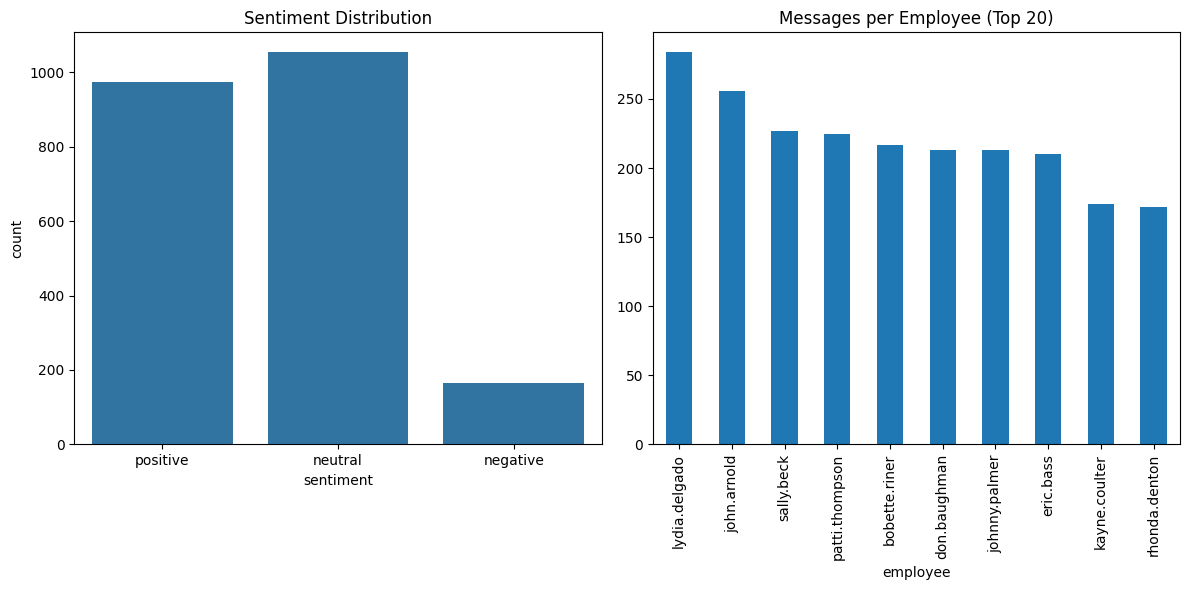


=== Monthly Rankings ===

Month: 2010-01
Top Positive Employees:
  kayne.coulter: 5
  patti.thompson: 5
  don.baughman: 4
Top Negative Employees:
  rhonda.denton: 0
  johnny.palmer: 1
  bobette.riner: 2

Month: 2010-02
Top Positive Employees:
  bobette.riner: 7
  john.arnold: 7
  don.baughman: 6
Top Negative Employees:
  lydia.delgado: 1
  patti.thompson: 1
  sally.beck: 1

Month: 2010-03
Top Positive Employees:
  sally.beck: 7
  lydia.delgado: 6
  bobette.riner: 4
Top Negative Employees:
  patti.thompson: 0
  rhonda.denton: 0
  eric.bass: 1

Month: 2010-04
Top Positive Employees:
  don.baughman: 5
  johnny.palmer: 4
  rhonda.denton: 4
Top Negative Employees:
  eric.bass: 1
  patti.thompson: 1
  bobette.riner: 2

Month: 2010-05
Top Positive Employees:
  don.baughman: 8
  patti.thompson: 7
  sally.beck: 6
Top Negative Employees:
  johnny.palmer: 0
  bobette.riner: 1
  john.arnold: 1

Month: 2010-06
Top Positive Employees:
  don.baughman: 8
  patti.thompson: 6
  john.arnold: 5
Top Negat

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/test(in).csv')

# Data cleaning and preparation
# Extract employee name from email
df['employee'] = df['from'].str.split('@').str[0]

# Convert date to datetime and ensure proper format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['date'])

# Task 1: Sentiment Labeling
def get_sentiment(text):
    analysis = TextBlob(str(text))
    if analysis.sentiment.polarity > 0.1:
        return 'positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['body'].apply(get_sentiment)

# Task 2: Exploratory Data Analysis (EDA)
print("\n=== Sentiment Distribution ===")
print(df['sentiment'].value_counts())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution')

plt.subplot(1, 2, 2)
df['employee'].value_counts().head(20).plot(kind='bar')  # Show top 20 employees
plt.title('Messages per Employee (Top 20)')
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

# Task 3: Employee Score Calculation
score_map = {'positive': 1, 'negative': -1, 'neutral': 0}
df['score'] = df['sentiment'].map(score_map)

# Monthly scores
df['month'] = df['date'].dt.to_period('M')
monthly_scores = df.groupby(['employee', 'month'])['score'].sum().reset_index()

# Task 4: Employee Ranking
def get_top_employees(df, n=3, positive=True):
    if positive:
        return df.sort_values(['score', 'employee'], ascending=[False, True]).head(n)
    else:
        return df.sort_values(['score', 'employee'], ascending=[True, True]).head(n)

# Get rankings for all months
all_months = monthly_scores['month'].unique()
rankings = {}

for month in all_months:
    month_data = monthly_scores[monthly_scores['month'] == month]
    rankings[month] = {
        'top_positive': get_top_employees(month_data, positive=True)[['employee', 'score']].values.tolist(),
        'top_negative': get_top_employees(month_data, positive=False)[['employee', 'score']].values.tolist()
    }

# Print rankings
print("\n=== Monthly Rankings ===")
for month, ranks in rankings.items():
    print(f"\nMonth: {month}")
    print("Top Positive Employees:")
    for emp, score in ranks['top_positive']:
        print(f"  {emp}: {score}")
    print("Top Negative Employees:")
    for emp, score in ranks['top_negative']:
        print(f"  {emp}: {score}")

# Task 5: Flight Risk Identification - Fixed Implementation
# First create a negative message indicator
df['is_negative'] = (df['sentiment'] == 'negative').astype(int)

# Sort by employee and date
df_sorted = df.sort_values(['employee', 'date']).set_index('date')

# Calculate rolling 30-day negative counts per employee
def count_negatives(group):
    return group.rolling('30D')['is_negative'].sum()

df_sorted['negative_count'] = (df_sorted.groupby('employee', group_keys=False)
                              .apply(count_negatives))

# Identify flight risks (employees with 4+ negatives in any 30-day window)
flight_risks = (df_sorted[df_sorted['negative_count'] >= 4]
               .groupby('employee')['negative_count'].max()
               .sort_values(ascending=False).index.tolist())

print("\n=== Flight Risk Employees ===")
print(flight_risks)

# Task 6: Predictive Modeling
# Prepare features
model_data = monthly_scores.copy()
model_data['prev_score'] = model_data.groupby('employee')['score'].shift(1)
message_counts = df.groupby(['employee', 'month']).size().reset_index(name='message_count')
model_data = pd.merge(model_data, message_counts, on=['employee', 'month'])
model_data = model_data.dropna()

# Split data
X = model_data[['prev_score', 'message_count']]
y = model_data['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\n=== Model Performance ===")
print(f"R-squared: {r2_score(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nFeature Importance:")
print(importance)

# Save outputs
monthly_scores.to_csv('monthly_scores.csv', index=False)

with open('flight_risks.txt', 'w') as f:
    f.write("Flight Risk Employees (4+ negative messages in 30-day window):\n")
    f.write("=============================================================\n\n")
    for emp in flight_risks:
        f.write(f"{emp}\n")

with open('rankings_summary.txt', 'w') as f:
    f.write("Monthly Employee Rankings\n")
    f.write("========================\n\n")
    for month, ranks in rankings.items():
        f.write(f"Month: {month}\n")
        f.write("Top Positive Employees:\n")
        for emp, score in ranks['top_positive']:
            f.write(f"  {emp}: {score}\n")
        f.write("Top Negative Employees:\n")
        for emp, score in ranks['top_negative']:
            f.write(f"  {emp}: {score}\n")
        f.write("\n")

print("\n=== Analysis Complete ===")
print("Output files created:")
print("- monthly_scores.csv")
print("- flight_risks.txt")
print("- rankings_summary.txt")
print("- sentiment_distribution.png")